In [241]:
%matplotlib inline

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)

import imageio

from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries, mark_boundaries
from skimage.morphology import remove_small_objects

from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage.measurements import center_of_mass

from utoolbox.container import Volume
from utoolbox.segmentation import chan_vese

In [220]:
folder = "data/RFiSHp2aLFCYC/decon/488"
files = []
for fname in os.listdir(folder):
    if fname.endswith(".tif"):
        files.append(os.path.join(folder, fname))

Load new data, deconvolved and resampled.

In [222]:
data = Volume(files[1])
print(data.shape)
print(data.dtype)

(140, 810, 810)
float32


Most algorithms like to process in unit quantity, aka, [0, 1].

In [223]:
data = rescale_intensity(data, out_range=(0., 1.))

Generate XY MIP.

In [224]:
data = np.amax(data, axis=0)
imageio.volwrite("data/ruffling_2d/mip.tif", data)

Perform the segmentation and save it.

In [225]:
#TODO bug, implicitly set ndim in utooblox.container.Volume as 3 causes problems
data = data.view(np.ndarray)

mask = chan_vese(
    data, 
    mu=1e-2, tol=1e-4, max_iter=500, dt=1.0, 
    init_level_set='checkerboard'
)

imageio.imwrite("data/ruffling_2d/mask.tif", rescale_intensity(mask.astype(np.int32)))

Filled the holes in the mask.

In [242]:
mask_filled = binary_fill_holes(mask)
mask_filled = remove_small_objects(mask_filled, min_size=256, in_place=True)

imageio.imwrite("data/ruffling_2d/mask_filled.tif", rescale_intensity(mask_filled.astype(np.int32)))

Extract the contour - boundary between foreground and background.

In [243]:
contour = find_boundaries(mask_filled, mode='outer')

imageio.imwrite("data/ruffling_2d/contour.tif", rescale_intensity(contour.astype(np.int32)))

indices = np.where(contour == True)
coords = pd.DataFrame({'x': indices[1], 'y': indices[0]})

Find COM.

In [244]:
com = center_of_mass(mask)
print("({:.4f}, {:.4f})".format(com[0], com[1]))

(427.5923, 445.2297)


Convert contour to polar coordinate system (with respect to the COM).

In [245]:
r = np.sqrt((indices[1]-com[0])**2 + (indices[0]-com[1])**2)
theta = np.arctan2((indices[0]-com[1]), (indices[1]-com[0]))

coords['r'] = pd.Series(r, index=coords.index)
coords['theta'] = pd.Series(theta, index=coords.index)

Bin to specified regions for polar chart visualization and compute averaged directional distance.

In [246]:
n_bins = 24
bins = np.linspace(-np.pi, np.pi, n_bins+1, dtype=np.float32)
cardinal = np.digitize(theta, bins)-1
coords['cardinal'] = pd.Series(cardinal, index=coords.index)

dist = np.zeros(n_bins, dtype=np.float32)
n_dist = np.zeros(n_bins, dtype=np.int32)
for c, d in zip(cardinal, r):
    dist[c] = max(dist[c], d)
dist /= np.amax(dist)

<Container object of 24 artists>

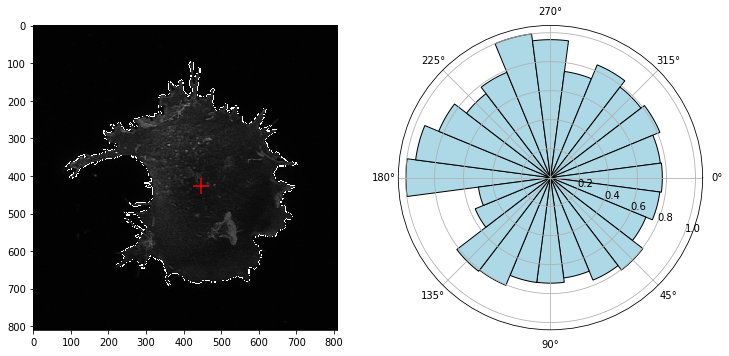

In [247]:
data_contour = mark_boundaries(data, contour, color=(1, 1, 1))
plt.subplot(1, 2, 1)
plt.imshow(data_contour, cmap='jet')
plt.scatter(com[1], com[0], s=250, c='red', marker='+')

pol_grid = np.linspace(-np.pi, np.pi, n_bins, endpoint=False)
ax = plt.subplot(1, 2, 2, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('E')
ax.bar(pol_grid, dist, width=2*np.pi/n_bins, color='lightblue', edgecolor='k')

In [236]:
def g_test():
    for i in range(0, 5):
        yield i

y = g_test()
print(type(g_test()))

next(y)

<class 'generator'>


0

([<matplotlib.projections.polar.RadialTick at 0x16ccfa550>,
 <a list of 3 Text yticklabel objects>)

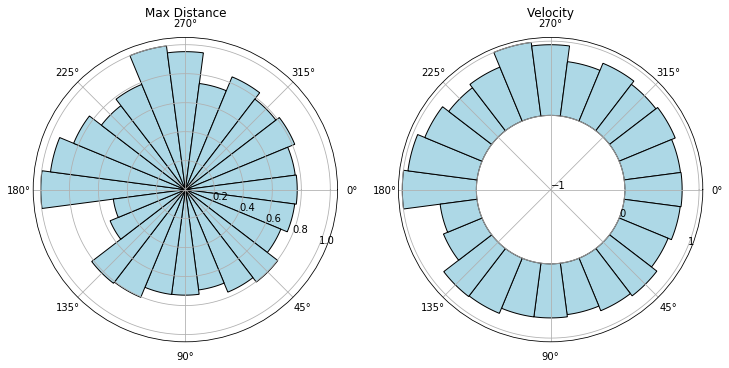

In [248]:
ax = plt.subplot(1, 2, 1, projection='polar')
plt.title('Max Distance')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('E')
ax.bar(pol_grid, dist, width=2*np.pi/n_bins, color='lightblue', edgecolor='k')

ax = plt.subplot(1, 2, 2, projection='polar')
plt.title('Velocity')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('E')
ax.bar(pol_grid, dist, width=2*np.pi/n_bins, color='lightblue', edgecolor='k')
plt.yticks([-1, 0, 1])